<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Introduction to the FlowAccumulator

Landlab directs flow and accumulates it using two types of components:

**FlowDirectors** use the topography to determine how flow moves between adjacent nodes. For every node in the grid it determines the nodes to receive flow and the proportion of flow to send from one node to its receiver. 

The **FlowAccumulator** uses the direction and proportion of flow moving between each node and (optionally) water runoff to calculate drainage area and discharge.  

In this tutorial we will go over how to initialize and run the **FlowAccumulator**. For tutorials on how to initialize and run a **FlowDirector** and a brief comparison between the different flow direction algorithms or for more detailed examples that contrast the differences between each flow direction algorithm, refer to the other tutorials in this section. 

First, we import the necessary python modules and make a small plotting routine. 

In [1]:
%matplotlib inline

In [2]:
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl

# import numpy
import numpy as np

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator
from landlab.components import (FlowDirectorD8, FlowDirectorDINF,
                                FlowDirectorMFD, FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter

# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot


# create a plotting routine to make a 3d plot of our surface.
def surf_plot(mg,
              surface='topographic__elevation',
              title='Surface plot of topography'):

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z - Z.min()) / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Topographic grids

For this tutorial we will consider one topographic surface. Here it is plotted in three dimensions. 

<ipython-input-2-b05bddb88328>:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


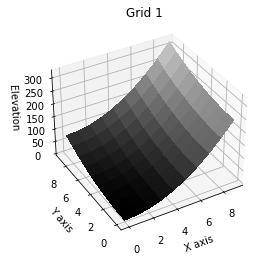

In [3]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
surf_plot(mg, title='Grid 1')

## Initalizing and running the FlowAccumulator

To instantiate the **FlowAccumulator**, you must pass it the minimum of a model grid that has a field called ```'topographic__elevation'```. 

Alternatively, you can pass it the name of another field name at node, or an array with length number of nodes. This is the surface over which flow is first directed and then accumulated. 

**FlowAccumulator** will create and use a **FlowDirector** to calculate flow directions. The default **FlowDirector** is **FlowDirectorSteepest**, which is the same as D4 in the special case of a raster grid. There are a few different ways to specify which **FlowDirector** you want **FlowAccumulator** to use. The next section will go over these options. 

**FlowAccumulator** can take a constant or spatially variable input called ```runoff_rate```, which it uses to calculate discharge. Alternatively, if there is an `at_node` field called ```water__unit_flux_in``` and no value is specified as the ```runoff_rate```, **FlowAccumulator** will use the values stored in ```water__unit_flux_in```.

In addition to directing flow and accumulating it in one step, **FlowAccumulator** can also deal with depression finding internally. This can be done by passing a **DepressionFinder** to the keyword argument ```depression_finder```. The default behavior is to not deal with depressions internally. 

Finally, if the **FlowDirector** you are using takes any keyword arguments, those can be passed to the **FlowAccumulator**. For example, **FlowDirectorMFD** has to option to use diagonals in addition to links and to proportion flow based on either the slope or the the square root of slope.

In [4]:
fa = FlowAccumulator(mg)

# this is the same as writing:
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director='FlowDirectorSteepest',
                     runoff_rate=None,
                     depression_finder=None)

The **FlowAccumulator** has two public methods: ```run_one_step()``` and ```accumulate_flow()```.

Both use the values of the surface provided to identify flow directions (and in the case of directing to more than one receiver, proportions) and then calculate discharge and drainage area. Both store the same information about receivers, proportions, and other calculated values to the model grid as fields. The difference is that ```run_one_step()``` does not return any values, while ```accumulate_flow()``` returns the drainage area and discharge as variables.

In [5]:
fa.run_one_step()

(da, q) = fa.accumulate_flow()

We can illustrate the receiver node **FlowDirectionSteepest** has assigned to each donor node using a plotting function in Landlab called ```drainage_plot```. We will see many of these plots in this tutorial so let's take a moment to walk through the plot and what it contains. 

   - The background image (white to black) shows the values of topographic elevation of the underlying surface or any other at_node field we choose to plot.

   - The colors of the dots inside of each pixel show the locations of the nodes and the type of node. 

   - The arrows show the direction of flow, and the color shows the proportion of flow that travels along that link. 

   - An X on top of a node indicates that node is a local sink and flows to itself. 

Note that in Landlab *Boundary Nodes*, or nodes that are on the edge of a grid, do not have area and do not contribute flow to nodes. These nodes can either be *Fixed Gradient Nodes*, *Fixed Value Nodes*, or *Closed Nodes*. With the exception of *Closed Nodes* the boundary nodes can receive flow. 

An important step in all flow direction and accumulation is setting the proper boundary condition. Refer to the boundary condition tutorials for more information.  

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


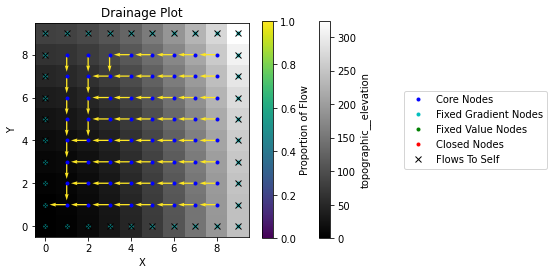

In [6]:
plt.figure()
drainage_plot(mg)

In this drainage plot, we can see that all of the flow is routed down the steepest link. A plot of the drainage area would illustrate how the flow would move. Next let's make a similar plot except that instead of plotting the topographic elevation as the background, we will plot the drainage area. 

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


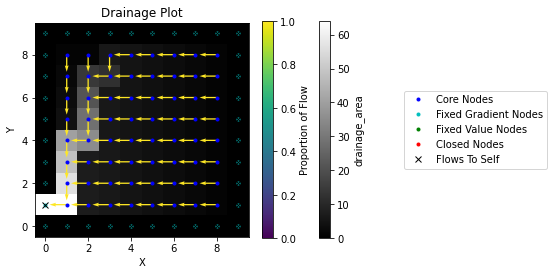

In [7]:
plt.figure()
drainage_plot(mg, 'drainage_area')

If we print out the drainage area, we can see that its maximum reaches 64, which is the total area of the interior of the grid.

In [8]:
print(mg.at_node['drainage_area'].reshape(mg.shape))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 64.  64.   7.   6.   5.   4.   3.   2.   1.   0.]
 [  0.  56.   7.   6.   5.   4.   3.   2.   1.   0.]
 [  0.  48.   7.   6.   5.   4.   3.   2.   1.   0.]
 [  0.  40.  35.   6.   5.   4.   3.   2.   1.   0.]
 [  0.   4.  28.   6.   5.   4.   3.   2.   1.   0.]
 [  0.   3.  21.   6.   5.   4.   3.   2.   1.   0.]
 [  0.   2.  14.  12.   5.   4.   3.   2.   1.   0.]
 [  0.   1.   1.   6.   5.   4.   3.   2.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


This is the same number as the number of core nodes. This makes sense becaue these are the only nodes in Landlab that have area, and in our model grid they each have an area of one. 

In [9]:
print(mg.number_of_core_nodes)

64


We can rain on the surface, store that rain in the field ```water__unit_flux_in```, and then re-run the **FlowAccumulator**. As an example, we will 'rain' a uniformly distributed random number between 0 and 1 on every node. 

Since we already ran the **FlowAccumulator**, under the hood our grid already has a field called ```water__unit_flux_in``` and we need to set the ```clobber``` keyword to ```True```.

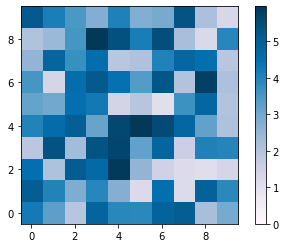

In [10]:
rain = 1. + 5. * np.random.rand(mg.number_of_nodes)

plt.imshow(rain.reshape(mg.shape), origin='lower', cmap='PuBu', vmin=0)
plt.colorbar()
plt.show()

_ = mg.add_field('water__unit_flux_in', rain, at='node', clobber=True)

Next, we re-run the **FlowAccumulator** and plot the discharge. 

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


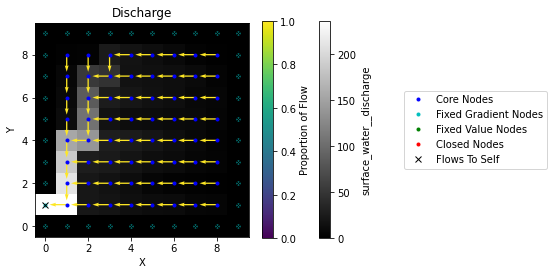

In [11]:
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

The basic pattern of drainage is the same but the values for the surface water discharge are different than for drainage area. 

### Alternative ways to specify the FlowDirector

**FlowAccumulator** allows the **FlowDirector** to be specified one of four ways:
1. As a string of the full name of the **FlowDirector** (e.g., ```'FlowDirectorSteepest'``` or ```'FlowDirectorD8'``` )
2. As a string of the short name of the **FlowDirector** method (e.g., ```'Steepest'``` or ```'D8'```)
3. As the class name for the desired **FlowDirector** component.
4. As an instantiated version of a **FlowDirector** component. 

Thus, the following four ways to instantiate a **FlowAccumulator** are equivalent.

In [12]:
# option 1: Full name of FlowDirector
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director='FlowDirectorSteepest')

# option 2: Short name of FlowDirector
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director='Steepest')

# option 3: Uninstantiated FlowDirector Component
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director=FlowDirectorSteepest)

# option 4: Instantiated FlowDirector Component
fd = FlowDirectorSteepest(mg)
fa = FlowAccumulator(mg, surface='topographic__elevation', flow_director=fd)

### Providing a DepressionFinder

Just as with providing the **FlowDirector**, the **DepressionFinder** can be provided multiple ways. While there are presently four different **FlowDirectors** in Landlab, there is only one **DepressionFinder**. 

1. As a string of the full name of the **DepressionFinder** (e.g., ```'DepressionFinderAndRouter'```)
2. As the class name of the **DepressionFinder** component.
3. As an instantiated version of a **DepressionFinder** component. 

NOTE: The current Landlab depression finder only works with **FlowDirectorSteepest** and **FlowDirectorD8** no matter how the depression finder is run. This is because the depression finder presently only works with route-to-one methods. 

Thus, the following three ways to instantiated a **DepressionFinder** are equivalent.

In [13]:
# option 1: Full name of FlowDirector
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director='FlowDirectorD8',
                     depression_finder='DepressionFinderAndRouter')

# option 2: Uninstantiated FlowDirector Component
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director=FlowDirectorD8,
                     depression_finder='DepressionFinderAndRouter')

# option 3: Instantiated FlowDirector Component
fd = FlowDirectorD8(mg)
df = DepressionFinderAndRouter(mg)
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director=fd,
                     depression_finder=df)

Methods for specifying can be mixed, such that the following is permissible. 

In [14]:
df = DepressionFinderAndRouter(mg)
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director='D8',
                     depression_finder=df)

### Using the DepressionFinder with FlowAccumulator

To conclude this tutorial, we examine an example of a Hexagonal Model grid with a depression.

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)


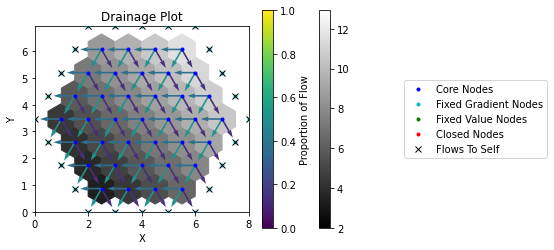

In [15]:
hmg = HexModelGrid((9, 5))
_ = hmg.add_field('topographic__elevation',
                  hmg.x_of_node + hmg.y_of_node,
                  at='node')

fa = FlowAccumulator(hmg, flow_director='MFD')
fa.run_one_step()
plt.figure()
drainage_plot(hmg)

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)


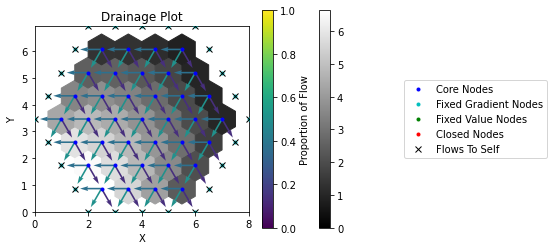

In [16]:
plt.figure()
drainage_plot(hmg, 'drainage_area')

We will put a depression in the middle of the topography, and then see what the drainage plot looks like. 

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)


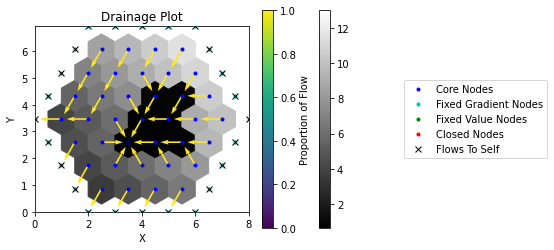

In [17]:
hmg_hole = HexModelGrid((9, 5))
z = hmg_hole.add_field('topographic__elevation',
                       hmg_hole.x_of_node + np.round(hmg_hole.y_of_node),
                       at='node')
hole_nodes = [21, 22, 23, 30, 31, 39, 40]
z[hole_nodes] = z[hole_nodes] * 0.1

fa = FlowAccumulator(hmg_hole, flow_director='Steepest')
fa.run_one_step()
plt.figure()
drainage_plot(hmg_hole)

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)


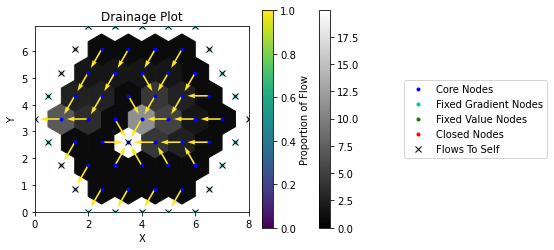

In [18]:
plt.figure()
drainage_plot(hmg_hole, 'drainage_area')

As you can see, the flow gets stuck in the hole. We'd like the flow in the hole to move out and to the boundary. 

To route the flow out of the hole, we have two options. 
1. Run the **FlowAccumulator** and then the **DepressionFinder**
2. Run them together in **FlowAccumulator**. 

The options look like the following and they are equivalent. 

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)


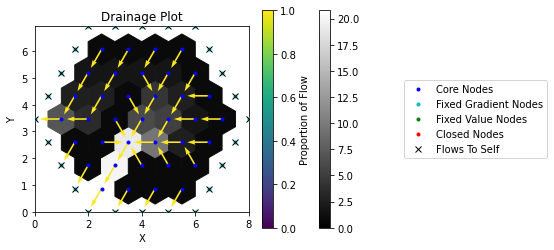

In [19]:
# OPTION 1
fa = FlowAccumulator(hmg_hole, flow_director='Steepest')
fa.run_one_step()

df = DepressionFinderAndRouter(hmg_hole)
df.map_depressions()

# OPTION 2
fa = FlowAccumulator(hmg_hole,
                     flow_director='Steepest',
                     depression_finder='DepressionFinderAndRouter')
fa.run_one_step()
plt.figure()
drainage_plot(hmg_hole, 'drainage_area')

As you can see the flow is now routed out of the hole and down to a boundary. 

# Conclusion

This tutorial went over how to run the **FlowAccumulator**. To learn more, consider one of two additional tutorials about directing and accumulating flow in Landlab:

1. **Introduction to FlowDirector**: A tutorial that goes over the different **FlowDirectors** present in Landlab and how to create and run a **FlowDirector**.

2. **Comparison of FlowDirectors**: A tutorial that constrasts the different methods in more detail and over surfaces that are more complicated than a simple sloping ramp. 

